# Прогноз оттока клиентов

## Описание задачи

  Отдел маркетинга провел исследование и выяснил, что в последнее время из нашей компании все чаще начали уходить клиенты к конкурентам. Стоимость маркетинговых затрат на возврат ушедшего клиента весьма высока, дешевле удержать клиента.
  
  Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.
  
  В связи с этим <i>необходимо разработать модель прогнозирования оттока клиентов</i>.

### План работы

1. Загрузка данных.
2. Предобработка данных - работа с пропусками, дубликатами и так далее.
3. Исследовательский анализ, который включает в себя поиск аномальных значений, анализ полезных признаков, выявление закономерностей.
4. Построение и обучение моделей с подбором гиперпараметров. RandomForest, LightGBM и полносвязную нейронную сеть.
5. Тестирование лучшей модели.

### Цель проекта

Небходимо построить и обучить модель, которая спрогнозирует уход клиента. Используя метрику ROC-AUC, необходимо добиться точности модели не менее 0.75.

## Загрузка данных

Имортируем необходимые библиотеки для анализа данных:

In [2]:
!pip install phik

     |████████████████████████████████| 709 kB 2.6 MB/s eta 0:00:01


In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import phik
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

У нас в распоряжении 4 таблицы:
 * contract.csv - информация о договоре;
 * internet.csv - информация об интернет-услугах;
 * personal.csv - персональные данные клиента;
 * phone.csv - информация об услугах телефонии.

In [4]:
path = '/datasets/final_provider/'

contract = pd.read_csv(path + 'contract.csv')
internet = pd.read_csv(path + 'internet.csv')
personal = pd.read_csv(path + 'personal.csv')
phone = pd.read_csv(path + 'phone.csv')

del path

В следующих пунктах мы выведем по 5 строк каждой таблицы для оценки столбцов, а также общую информацию для проверки на типы данных и пропуски. Затем посчитаем дубликаты.

### Contract

In [5]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


Описание столбцов:
 * customerID - id клиента
 * BeginDate - дата подписания договора
 * EndDate - дата расторжения договора
 * Type - тип платежа за услуги
 * PaperlessBilling - безбумажное выставление счетов
 * PaymentMethod - способ оплаты
 * MonthlyCharges - сумма ежемесячных платежей
 * TotalCharges - общая сумма платежей

In [6]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Пропуски в данных отсутствуют.

### Internet

In [7]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Описание столбцов:
 * customerID - id клиента
 * InternetService - тип подключения
 * OnlineSecurity - блокировка небезопасных сайтов
 * OnlineBackup - облачное хранилище файлов для резервного копирования данных
 * DeviceProtection - антивирус
 * Tech Support - выделенная линия технической поддержки
 * StreamingTV - стриминговое телевидение
 * StreamingMovies - каталог фильмов

In [8]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Пропуски отсутствуют.

### Personal

In [9]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Описание столбцов:
 * customerID - id клиента
 * gender - пол пользователя
 * SeniorCitizen - пенсионер ли пользователь
 * Partner - есть ли партнер
 * Dependents - нетрудоспособный (инвалид/на попечении у кого-то)

In [10]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Пропусков нет.

### Phone

In [11]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Описание столбцов:
 * customerID - id клиента
 * MultipleLines - стационарная телефонная связь (услуга)

In [12]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [13]:
phone.columns = ['customer_id', 'multiple_lines']

## Предобработка данных

### Таблица Contract

**EndDate** - указывает на наш целевой признак. Сама дата нам не скажет многого, но нам необходим факт того что клиент расторгнул договор. Создадим отдельный столбец в котором будут всего 2 значения (0 и 1).

Создадим целевой признак - столбец **is_out**. В нем будет всего 2 класса.

In [14]:
contract['is_out'] = [0 if x=='No' else 1 for x in contract['EndDate']]
contract['is_out'].value_counts()

0    5174
1    1869
Name: is_out, dtype: int64

Пропуски отсутствуют, необходимо изменить тип столбца **TotalCharges**.

Остальные столбцы, которые могут нуждаться в изменении типа (например **PaperlessBilling**), все равно по итогу будут закодированы в дальнейшем.

Так же для удобной работы нужно будет привести названия столбцов к привычному стилю:

In [15]:
contract.columns = ['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing', 
                    'payment_method', 'monthly_charges', 'total_charges', 'is_out']
contract.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'is_out'],
      dtype='object')

Столбец **total_charges** нельзя привести к *float* из за строковых пробелов. Посмотрим сколько их:

In [16]:
contract[contract['total_charges'] == ' ']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,is_out
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,0
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,0
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,0
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,0
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,0
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,0
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,0
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,0
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,0
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,0


Все эти строки связывает то что договор подписан 2020-02-01. Суть в том что вся информация из таблиц актуальна как раз до этой даты. Значит эти люди просто не успели ничего оплатить. Будет вполне логично заполнить эти пропуски нулями.

In [17]:
contract['total_charges'] = contract['total_charges'].replace(' ', 0)

Теперь можно изменить тип данных без ошибок:

In [18]:
contract['total_charges'] = contract['total_charges'].astype(float)
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   float64
 8   is_out             7043 non-null   int64  
dtypes: float64(2), int64(1), object(6)
memory usage: 495.3+ KB


Рассмотрим уникальные значения столбцов для выявления ошибок в данных:

In [19]:
contract['type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: type, dtype: int64

In [20]:
contract['paperless_billing'].value_counts()

Yes    4171
No     2872
Name: paperless_billing, dtype: int64

In [21]:
contract['payment_method'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: payment_method, dtype: int64

Посчитаем дубликаты:

In [22]:
contract['customer_id'].duplicated().sum()

0

Дубликаты отсутствуют.

**Выводы**

 * is_out - целевой признак
 * Переименовали столбцы
 * Изменили тип данных некоторых столбцов
 * Проверили таблицу на ошибки, пропуски, дубликаты и исправили

### Таблица Internet

Переименуем столбцы:

In [23]:
internet.columns = ['customer_id', 'internet_service', 'online_security', 'online_backup', 
                    'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']

Поищем ошибки в данных, посмотрев на уникальные значения столбцов:

In [24]:
for column in internet.columns[1:]:
    print(column.upper())
    print(internet[column].value_counts(), '\n')

INTERNET_SERVICE
Fiber optic    3096
DSL            2421
Name: internet_service, dtype: int64 

ONLINE_SECURITY
No     3498
Yes    2019
Name: online_security, dtype: int64 

ONLINE_BACKUP
No     3088
Yes    2429
Name: online_backup, dtype: int64 

DEVICE_PROTECTION
No     3095
Yes    2422
Name: device_protection, dtype: int64 

TECH_SUPPORT
No     3473
Yes    2044
Name: tech_support, dtype: int64 

STREAMING_TV
No     2810
Yes    2707
Name: streaming_tv, dtype: int64 

STREAMING_MOVIES
No     2785
Yes    2732
Name: streaming_movies, dtype: int64 



Ошибки отсутствуют, посчитаем дубликаты:

In [25]:
internet['customer_id'].duplicated().sum()

0

Дубликаты отсутствуют.

### Таблица Personal

Переименуем столбцы:

In [26]:
personal.columns = ['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents']

Проверим уникальные значения аналогично прошлой таблице:

In [27]:
for column in personal.columns[1:]:
    print(column.upper())
    print(personal[column].value_counts(), '\n')

GENDER
Male      3555
Female    3488
Name: gender, dtype: int64 

SENIOR_CITIZEN
0    5901
1    1142
Name: senior_citizen, dtype: int64 

PARTNER
No     3641
Yes    3402
Name: partner, dtype: int64 

DEPENDENTS
No     4933
Yes    2110
Name: dependents, dtype: int64 



In [28]:
personal['customer_id'].duplicated().sum()

0

Ни дубликатов, ни ошибок в таблице нет.

Таблица **phone** не нуждается в предобработке.

## Исследовательский анализ

### Объединение таблиц

Таблицы **phone** и **internet** связаны - это услуги предоставляемые клиентам. Следовательно объединив эти таблицы по идентификатору клиента, мы получим все 7043 строки.

In [29]:
internet_phone = internet.merge(phone, on='customer_id', how='outer')
internet_phone

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...
7038,4807-IZYOZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
7039,9710-NJERN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
7040,9837-FWLCH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
7041,0871-OPBXW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No


Необходимо разобраться с пропусками. Если клиент не присутствовал в таблице **phone**, значит он не использовал эту услугу, значит пропуск в столбце *MultipleLines* можно заменить на "No". По этой логике мы обработаем остальные пропуски.

In [30]:
internet_phone = internet_phone.fillna('No')

Объеденим все таблицы в одну, для получения сырых признаков для будущих моделей.

Идентификаторы клиентов и даты нам не нужны в признаках, их мы вносить не будем в таблицу.

In [31]:
full = (contract.merge(personal, on='customer_id')
                .merge(internet_phone, on='customer_id')
                .drop(['customer_id', 'begin_date', 'end_date'], axis=1))
full

,type,paperless_billing,payment_method,monthly_charges,total_charges,is_out,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,Month-to-month,Yes,Electronic check,29.85,29.85,0,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No
1,One year,No,Mailed check,56.95,1889.50,0,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,Month-to-month,Yes,Mailed check,53.85,108.15,1,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,One year,No,Bank transfer (automatic),42.30,1840.75,0,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No
4,Month-to-month,Yes,Electronic check,70.70,151.65,1,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,One year,Yes,Mailed check,84.80,1990.50,0,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7039,One year,Yes,Credit card (automatic),103.20,7362.90,0,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7040,Month-to-month,Yes,Electronic check,29.60,346.45,0,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,No
7041,Month-to-month,Yes,Mailed check,74.40,306.60,1,Male,1,Yes,No,Fiber optic,No,No,No,No,No,No,Yes


### Аномальные значения

В таблице **contract** присутствуют количественные столбцы, стоит рассмотреть в них аномальные значения. Используем график *boxplot* для оценки.

AxesSubplot(0.125,0.125;0.775x0.755)


count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: monthly_charges, dtype: float64

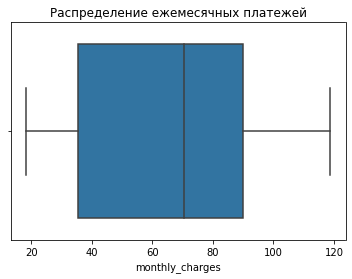

In [32]:
print(sns.boxplot(contract['monthly_charges']))
plt.title('Распределение ежемесячных платежей')
contract['monthly_charges'].describe()

Аномальные значения отсутствуют, теперь рассмотрим распределение общих сумм выплат:

count    7043.000000
mean     2279.734304
std      2266.794470
min         0.000000
25%       398.550000
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: total_charges, dtype: float64

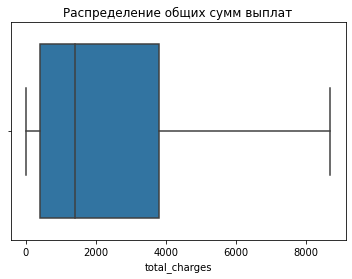

In [33]:
sns.boxplot(contract['total_charges'])
plt.title('Распределение общих сумм выплат')
contract['total_charges'].describe()

Медиана смещена влево. Возможно в больших значениях стоят люди, которые платят сразу за год/за два. Выведем тот же график, но теперь в зависимости от типа платежа:

Text(0.5, 1.0, 'Распределение обших сумм выплат по типу платежа')

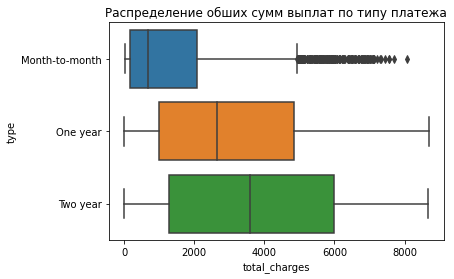

In [34]:
sns.boxplot(data=full, x='total_charges', y='type')
plt.title('Распределение обших сумм выплат по типу платежа')

Так и оказалось, также у типа *Month-to-month* присутствуют редкие значения. Рассмотрим гистограмму, чтобы оценить выбросы:

Text(0.5, 1.0, 'Распределение общих сумм выплат по типу Month-to-month')

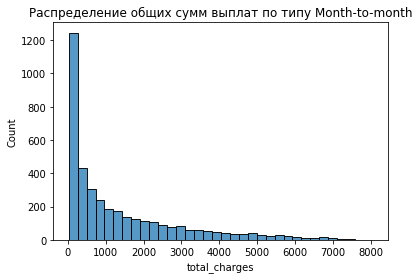

In [35]:
sns.histplot(full[full['type']=='Month-to-month']['total_charges'])
plt.title('Распределение общих сумм выплат по типу Month-to-month')

Редких значений достаточно много, можно вырезать значения свыше 3000.

<AxesSubplot:xlabel='total_charges', ylabel='type'>

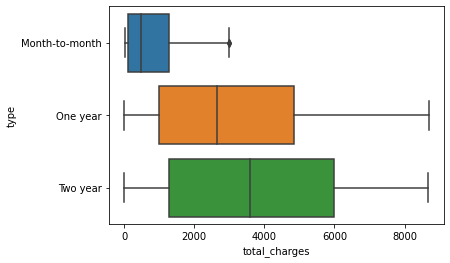

In [36]:
outliers_indexes = full[(full['type']=='Month-to-month') & (full['total_charges'] > 3000)].index

full = full.drop(outliers_indexes).reset_index(drop=True)

sns.boxplot(data=full, x='total_charges', y='type')

### Кодировка столбцов

Будем создавать признаки для обучения моделей, для этого необходимо провести кодировку данных.

Кодировать данные будем техникой **OrdinalEncoding**:

In [37]:
encoder = OrdinalEncoder()
column_names = full.drop(['monthly_charges', 'total_charges'], axis=1).columns

full_oe = pd.DataFrame(encoder.fit_transform(full[column_names]), columns=column_names)
full_oe['monthly_charges'] = full['monthly_charges']
full_oe['total_charges'] = full['total_charges']
full_oe.head()

,type,paperless_billing,payment_method,is_out,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,monthly_charges,total_charges
0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,29.85,29.85
1,1.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,56.95,1889.50
2,0.0,1.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,53.85,108.15
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,42.30,1840.75
4,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.70,151.65


Прежде чем делить данные, тщательнее проанализируем признаки, скорее всего мы не будем использовать их все.

### Анализ взаимосвязей


Посмотрим распределение каждого признака с заливкой по целевому признаку, с целью выявить и отбросить наименее полезные признаки:

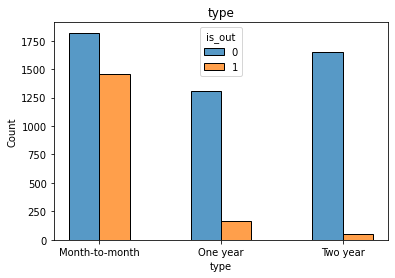

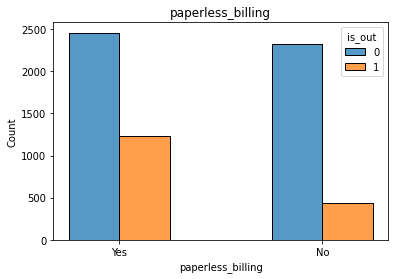

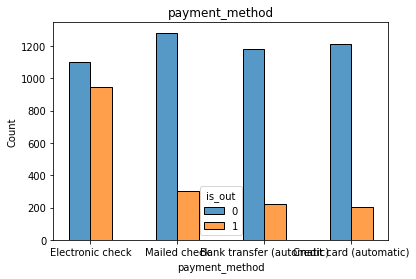

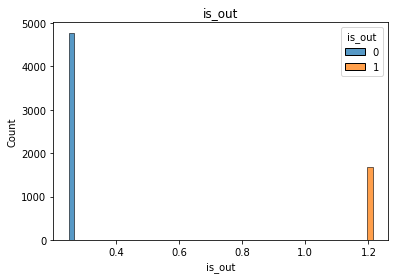

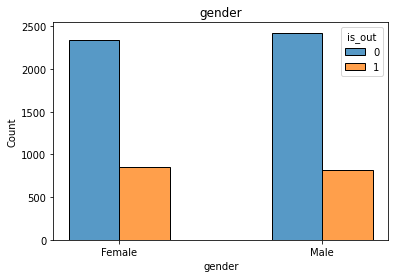

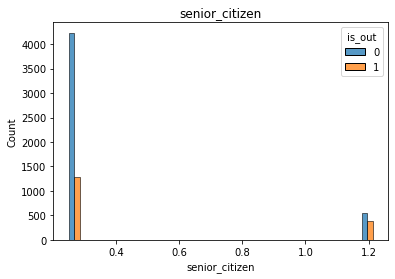

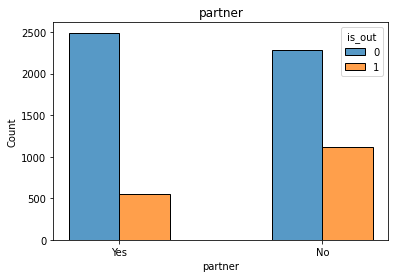

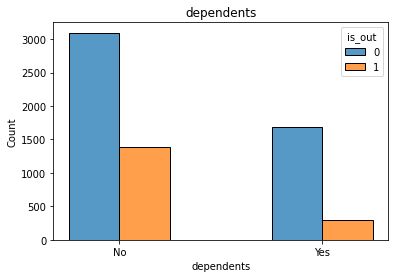

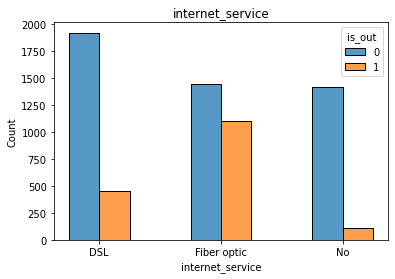

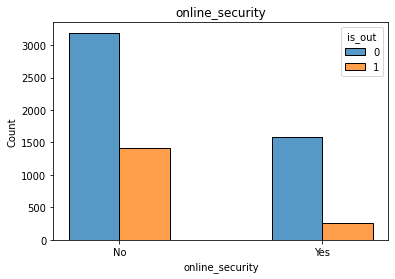

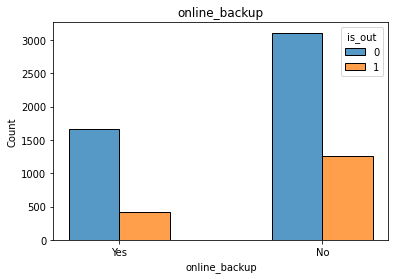

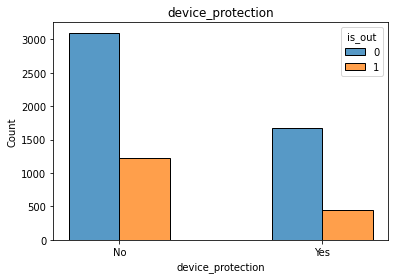

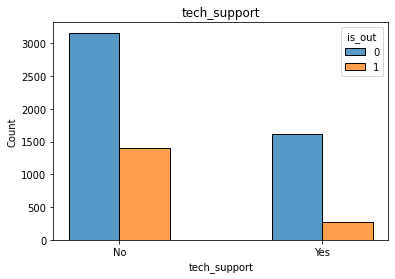

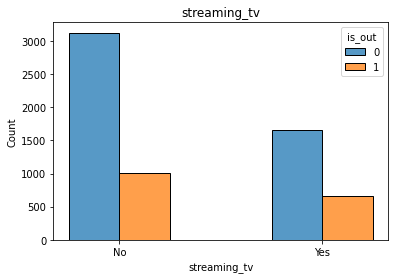

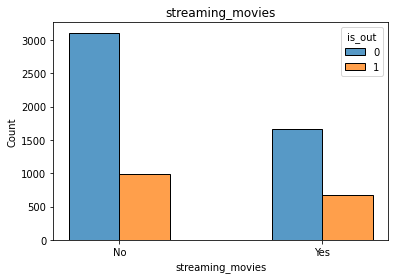

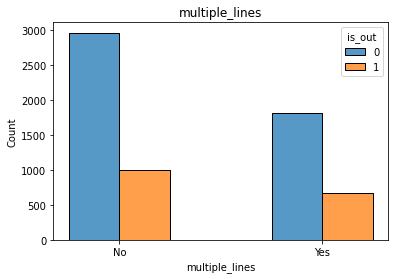

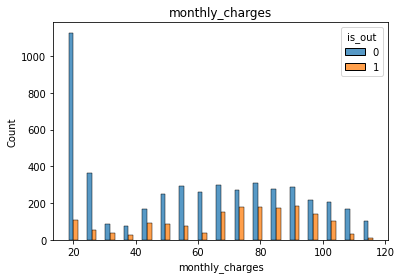

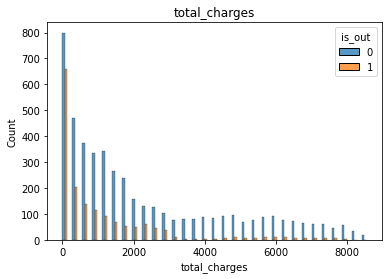

In [38]:
for column in full_oe.columns:
    sns.histplot(data=full, x=column, hue='is_out', multiple='dodge', shrink=0.5)
    plt.title(column)
    plt.show()

Cледует обратить внимание на гистограмму столбца *total_charges*. Слишком много людей в маленьких значениях: ушедших и неушедших. Большое количество ушедших можно объяснить тем, что человек в первый же месяц сделает выводы об услуге и он перестанет ей пользоваться, потому *total_charges* будет низким у ушедших людей. Можно нагляднее посмотреть по каким причинам они уходят так рано:

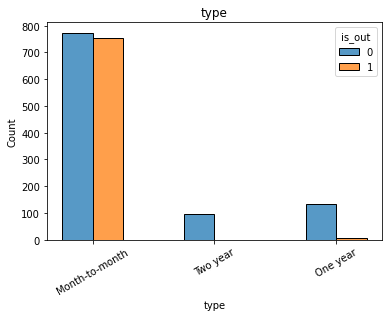

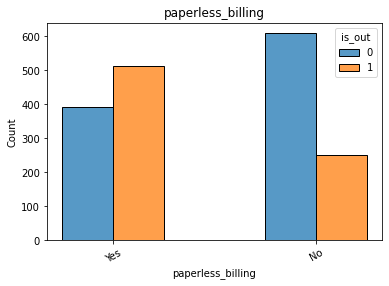

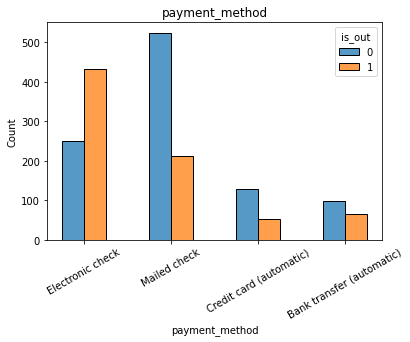

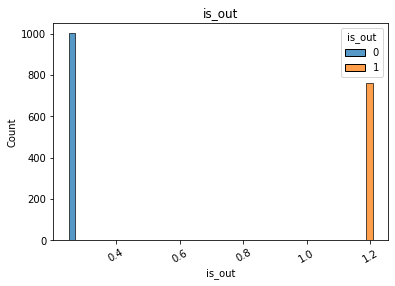

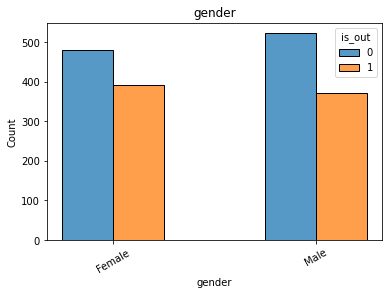

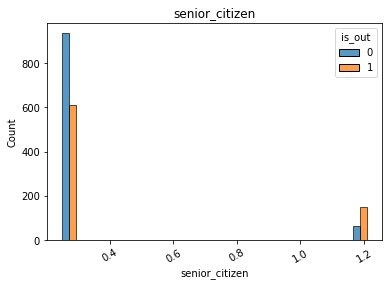

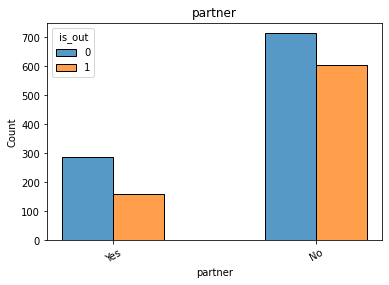

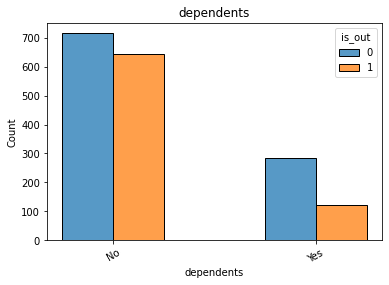

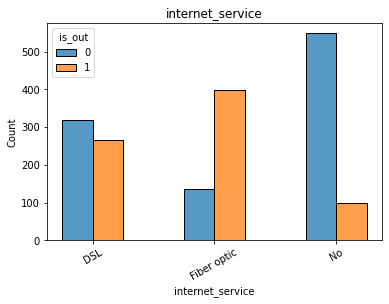

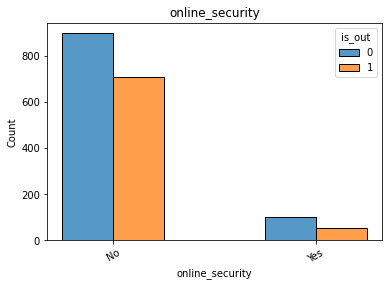

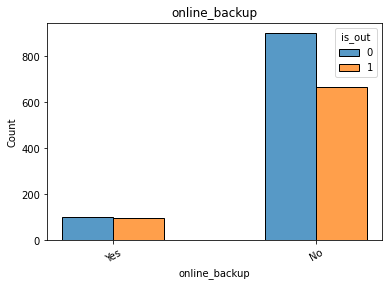

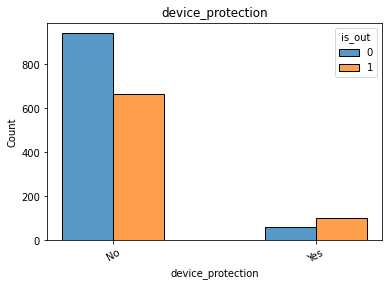

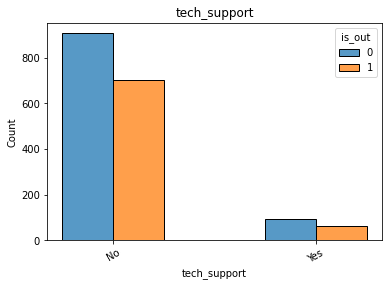

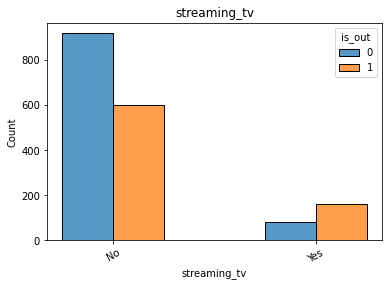

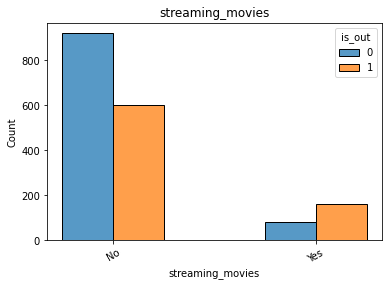

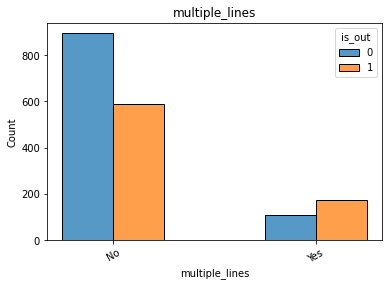

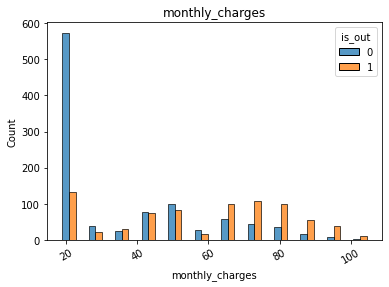

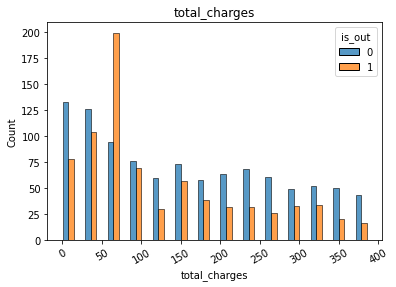

In [39]:
for column in full_oe.columns:
    sns.histplot(data=full[full['total_charges'] < 400], x=column, hue='is_out', multiple='dodge', shrink=0.5)
    plt.xticks(rotation=30)
    plt.title(column)
    plt.show()

График сильно отличается, построим графики по остальным значениям *total_charges*, чтобы легче было сравнивать:

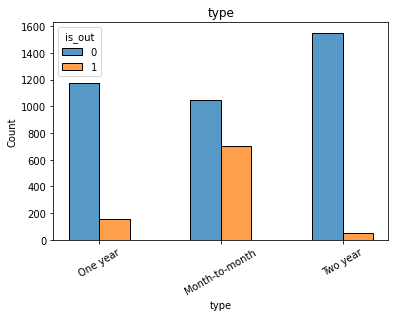

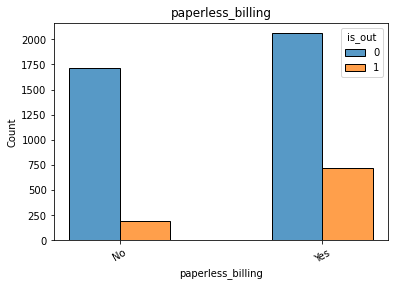

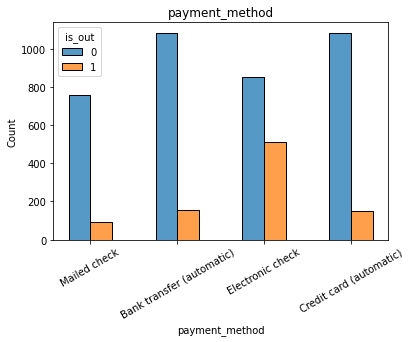

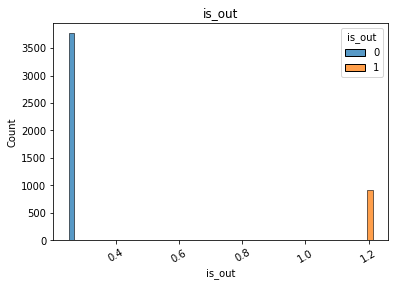

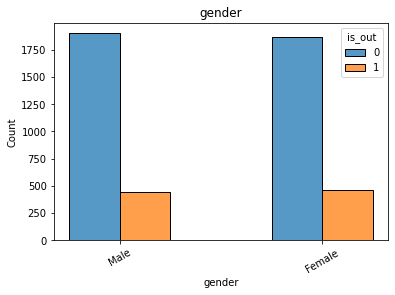

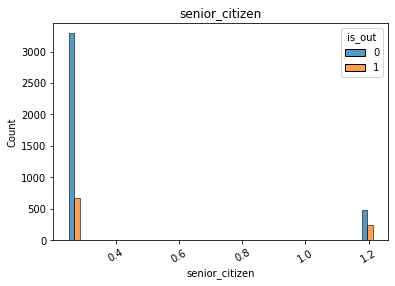

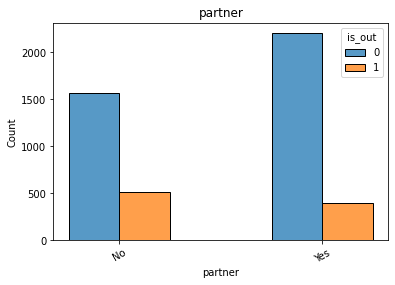

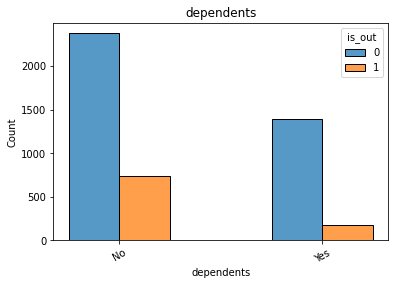

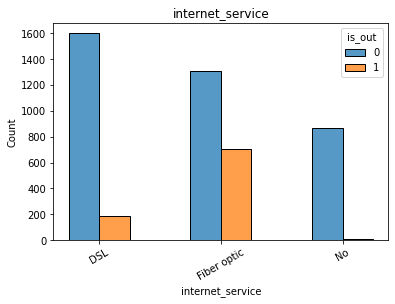

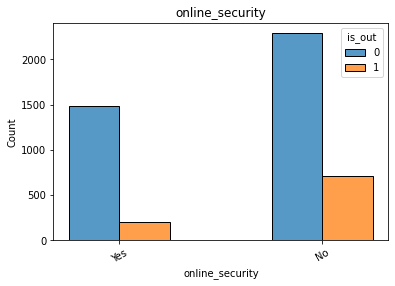

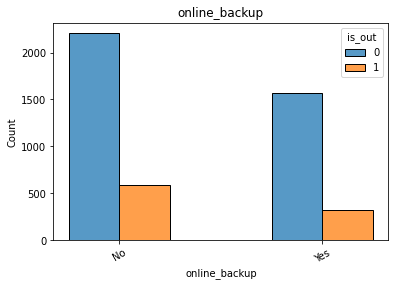

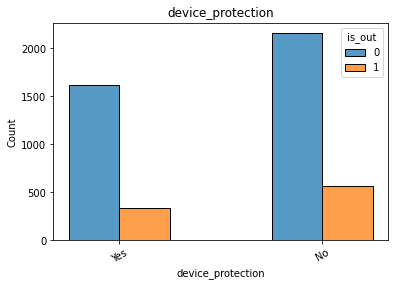

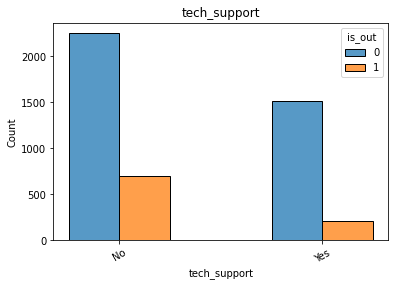

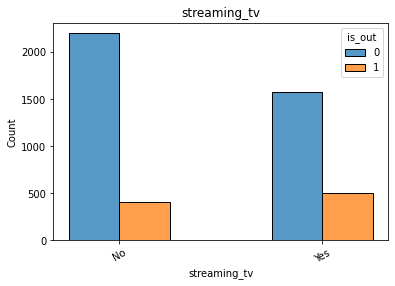

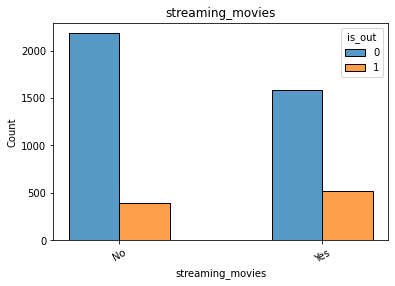

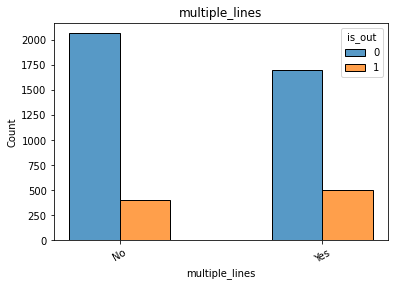

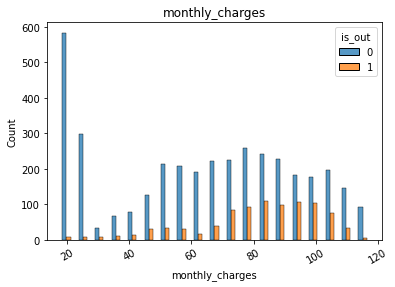

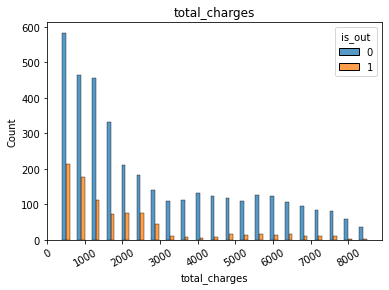

In [40]:
for column in full_oe.columns:
    sns.histplot(data=full[full['total_charges'] >= 400], x=column, hue='is_out', multiple='dodge', shrink=0.5)
    plt.xticks(rotation=30)
    plt.title(column)
    plt.show()

Отлично! Мы выявили важную информацию о признаках, которые сильнее остальных влияют на уход:
 * Люди с типом платежа Month-to-month, уходят гораздо чаще остальных типов
 * Безбумажный расчет
 * Электронный чек
 * Часто - высокая ежемесячная плата
 * У этих людей часто стоит Fiber optic (оптическое волокно)
 * Люди уходят в первые же месяцы, это объясняет скопление ушедших в начале графика распределения общих сумм выплат.

Все остальные признаки не повлияли на уход клиента. Однако, чтобы точно в этом убедиться посмотрим как признаки друг на друга влияют с помощью библиотеки **phik**.

### Создание признаков

Зададим признаки:

In [47]:
features = full_oe.drop('is_out', axis=1)
target = full_oe['is_out']

Разделим признаки на обучающую, валидационную и тестовую выборки в соотношении размеров 3:1:1

In [48]:
train_x, valid_x, train_y, valid_y = train_test_split(features, target, 
                                                    test_size=0.2, random_state=80822)
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, 
                                                   test_size=0.25, random_state=80822)

Убедимся в том, что получили нужные размеры выборок:

In [49]:
print('Обучающая -', train_x.shape)
print('Валидационная -', valid_x.shape)
print('Тестовая -', test_x.shape)

Обучающая - (3866, 17)
Валидационная - (1289, 17)
Тестовая - (1289, 17)


Используем библиотеку **phik** для проверки на мультиколлинеарность признаков. Выведем тепловую карту:

interval columns not set, guessing: ['type', 'paperless_billing', 'payment_method', 'is_out', 'gender', 'senior_citizen', 'partner', 'dependents', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines', 'monthly_charges', 'total_charges']


<AxesSubplot:>

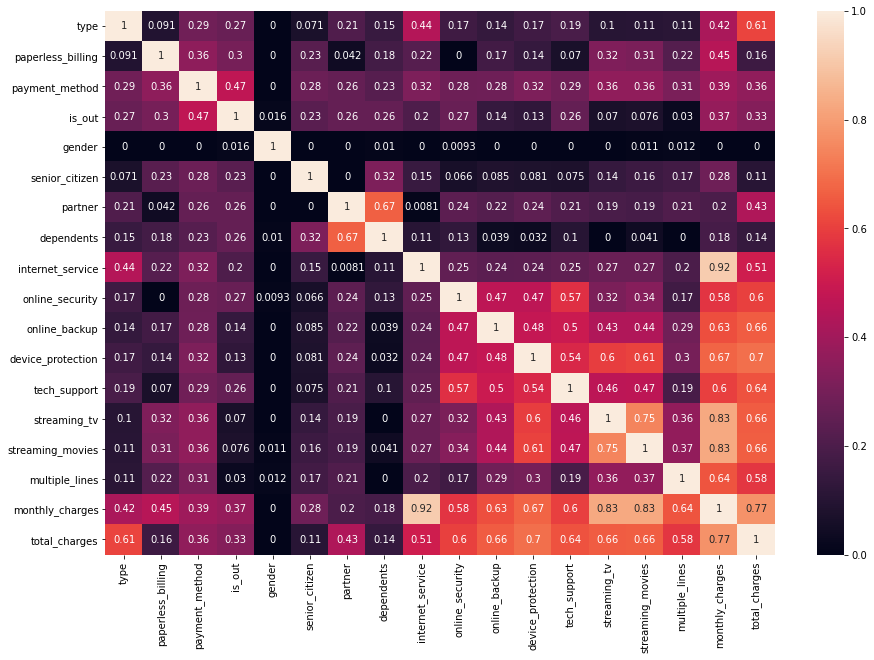

In [50]:
plt.figure(figsize=(15,10))
sns.heatmap(full_oe.phik_matrix(), annot=True)

Обнаружены следующие пары взаимосвязей:

1. Наличие партнера - инвалидность
2. Ежемесячные платежи - тип подключения
3. Все интернет-услуги коррелируют между собой
4. Ежемесячные платежи - общие выплаты

Удалим по одному признаку из каждой пары, а именно столбцы: 

* dependents
* monthly_charges
* online_security
* online_bacup
* device_protection
* tech_support
* streaming_tv
* streaming_movies

Посмотрим какие признаки, не считая вышеперечисленных, не влияют на целевой признак:

* gender
* multiple_lines

Оставим нужные признаки:

In [51]:
usefull_features = ['type', 'paperless_billing', 'payment_method', 'senior_citizen',
                    'partner', 'internet_service', 'total_charges']
   
train_x = train_x[usefull_features]
valid_x = valid_x[usefull_features]
test_x = test_x[usefull_features]

train_x.head()

,type,paperless_billing,payment_method,senior_citizen,partner,internet_service,total_charges
604,0.0,0.0,3.0,0.0,0.0,0.0,428.70
5484,0.0,0.0,2.0,0.0,0.0,0.0,1004.75
2330,2.0,1.0,1.0,0.0,0.0,1.0,7795.95
4120,2.0,0.0,1.0,0.0,1.0,0.0,6595.90
3189,0.0,0.0,2.0,0.0,0.0,0.0,214.55


### Дисбаланс классов

Создадим пару вариантов признаков, в будущем проверим какой из них дает лучший результат.

Устраняя дисбаланс классов мы будем использовать **Upsampling** и обычный **class_weight**. Для начала посмотрим на различия в балансе:

In [52]:
train_y.value_counts()

0.0    2837
1.0    1029
Name: is_out, dtype: int64

Единиц почти в 3 раза меньше. Напишем функцию которая будет увеличивать единички копированием объектов:

In [53]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
                        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

Применим ее, увеличив количество единичек в 2 раза:

In [54]:
x_upsampled, y_upsampled = upsample(train_x, train_y, 2)
y_upsampled.value_counts()

0.0    2837
1.0    2058
Name: is_out, dtype: int64

Баланс классов проведен.

## Построение моделей

### RandomForestClassifier

Функция для поиска гиперпараметров для экономии кода:

In [48]:
def get_params_rf(X, Y, class_weight=None):
    params = {'n_estimators': range(10,81),
              'max_depth': range(3, 15),
              'min_samples_leaf': range(1, 16, 2),
              'min_samples_split': range(2, 15, 2),
              'max_features': ['log2', 'sqrt'],
              'bootstrap': ['True', 'False']}

    search = RandomizedSearchCV(RandomForestClassifier(random_state=80822,
                                                       class_weight=class_weight),
                                param_distributions=params,
                                scoring='roc_auc',
                                random_state=80822)
    search.fit(X, Y)
    
    print('roc_auc =', abs(search.best_score_))
    print('Лучшие параметры: \n', search.best_params_)

В дальнейшем мы будем использовать две обучающие выборки. Внутренний баланс, где в настройке модели мы присваиваем *class_weight = 'balanced'*, и Upsampling, где используем сбалансированную выборку.

#### Внутренний баланс классов

Баланс классов будет осуществлять сама модель, мы присвоим ей гиперпараметр **class_weight='balanced'**, то есть обучим ее на *train_x*. Гиперпараметры будем подбирать инструментом **RandomizedSearchCV**:

In [49]:
get_params_rf(train_x, train_y, class_weight='balanced')

roc_auc = 0.8479483728525986
Лучшие параметры: 
 {'n_estimators': 28, 'min_samples_split': 8, 'min_samples_leaf': 11, 'max_features': 'sqrt', 'max_depth': 6, 'bootstrap': 'False'}


Протестируем на валидационной выборке:

In [50]:
model = RandomForestClassifier(random_state=80822,
                              class_weight='balanced',
                              n_estimators=28,
                              max_depth=6,
                              min_samples_leaf=11,
                              min_samples_split=8,
                              bootstrap='False',
                              max_features='sqrt')
model.fit(train_x, train_y)

probs = model.predict_proba(valid_x)
probs = probs[:, 1]
print('Прогноз по валидационной выборке: \n', roc_auc_score(valid_y, probs))

Прогноз по валидационной выборке: 
 0.8440362414988878


**Значение метрики - 0.844**

#### Upsampling

In [51]:
get_params_rf(x_upsampled, y_upsampled)

roc_auc = 0.8900255807978631
Лучшие параметры: 
 {'n_estimators': 24, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 14, 'bootstrap': 'True'}


Показывает немного лучшую точность, посмотрим что будет на тесте валидационной выборки:

In [52]:
model = RandomForestClassifier(random_state=80822,
                              n_estimators=24,
                              max_depth=14,
                              min_samples_leaf=1,
                              min_samples_split=4,
                              bootstrap='True',
                              max_features='sqrt')
model.fit(x_upsampled, y_upsampled)

probs = model.predict_proba(valid_x)
probs = probs[:, 1]
print('Прогноз по валидационной выборке: \n', roc_auc_score(valid_y, probs))

Прогноз по валидационной выборке: 
 0.8033783307373292


**Значение метрики - 0.803**

### LGBMClassifier

Мы использовали *RandomizedSearchCV* для нахождения гиперпараметров RandomForest, потому что циклом поиск идет от 5-ти минут. Для LGBMClassifier мы параметры получим циклом, сразу тестируя на валидационной выборке.

Функция для нахождения гиперпараметров:

In [53]:
def get_params_lgbm(X, Y, valid_x, valid_y, class_weight=None):
    best_score = 0
    best_model = None
    for n in range(1, 15, 3):
        for depth in range(3, 15, 3):
            for rate in np.arange(.1, 1, 0.1):
                for alpha in np.arange(.1, 1, .1):
                    model = LGBMClassifier(class_weight=class_weight,
                                           objective='binary',
                                           max_depth=depth,
                                           learning_rate=rate,
                                           n_estimators=n,
                                           reg_alpha=alpha,
                                           random_state=80822)
                    model.fit(X, Y, verbose=0)
                    probs = model.predict_proba(valid_x)
                    probs = probs[:, 1]
                    roc_auc =  roc_auc_score(valid_y, probs)
                    if roc_auc > best_score:
                        best_score = roc_auc
                        best_model = model
    print('roc_auc =', best_score)
    print(best_model)

#### Внутренний баланс классов

In [54]:
get_params_lgbm(train_x, train_y, valid_x, valid_y, class_weight='balanced')

roc_auc = 0.8559602330634772
LGBMClassifier(class_weight='balanced', learning_rate=0.7000000000000001,
               max_depth=3, n_estimators=13, objective='binary',
               random_state=80822, reg_alpha=0.30000000000000004)


**Значение метрики - 0.856**

#### Upsampling

In [55]:
get_params_lgbm(x_upsampled, y_upsampled, valid_x, valid_y)

roc_auc = 0.8574633514733125
LGBMClassifier(learning_rate=0.5, max_depth=3, n_estimators=7,
               objective='binary', random_state=80822,
               reg_alpha=0.30000000000000004)


**Значение метрики - 0.857**

### Нейронная сеть 

#### Обучение с внутренним балансом

Построим и обучим нейронную сеть и обучим на *train_x*, *train_y*:

In [56]:
optimizer = Adam(learning_rate=0.0002)

model = keras.models.Sequential()

model.add(keras.layers.Dense(units=54, input_dim=train_x.shape[1],
                        activation='relu'))
model.add(keras.layers.Dense(units=14, activation='relu'))
model.add(keras.layers.Dense(units=14, activation='relu'))
model.add(keras.layers.Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=keras.metrics.AUC(
                                                                            num_thresholds=200,
                                                                            curve='ROC',
                                                                            summation_method='interpolation'))

model.fit(train_x, train_y, epochs=200, class_weight={0:1, 1:3}, verbose=0)

print('Результат на валидационной выборке -', model.evaluate(valid_x, valid_y)[1])

2022-08-20 10:28:08.218869: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


41/41 [==============================] - 0s 1ms/step - loss: 0.5037 - auc: 0.8016
Результат на валидационной выборке - 0.8015707731246948


Вся архитектура была построена вручную.

**Значение метрики ~ 0.79**

#### Обучение на сбалансированной выборке

In [57]:
optimizer = Adam(learning_rate=0.0002)

model = keras.models.Sequential()

model.add(keras.layers.Dense(units=54, input_dim=train_x.shape[1],
                        activation='relu'))
model.add(keras.layers.Dense(units=14, activation='relu'))
model.add(keras.layers.Dense(units=14, activation='relu'))
model.add(keras.layers.Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=keras.metrics.AUC(
                                                                            num_thresholds=200,
                                                                            curve='ROC',
                                                                            summation_method='interpolation'))

model.fit(x_upsampled, y_upsampled, epochs=200, verbose=0)

print('Результат на валидационной выборке -', model.evaluate(valid_x, valid_y)[1])

41/41 [==============================] - 0s 1ms/step - loss: 0.4770 - auc_1: 0.8128
Результат на валидационной выборке - 0.812768816947937


**Значение метрики ~ 0.815**

### Итог

Мы протестировали 3 модели и получили следующие результаты:

In [42]:
index = ['RandomForest', 'LightGBM', 'NN']

columns = ['Balanced', 'Upsampled']

data = [[0.844, 0.803],
        [0.856, 0.857],
        [0.79, 0.815]]

ft = (pd.DataFrame(data=data,
            index=index,
            columns=columns)
        .style
        .highlight_max(color='yellowgreen')
        .highlight_min(color='red'))
ft

,Balanced,Upsampled
RandomForest,0.844000,0.803000
LightGBM,0.856000,0.857000
NN,0.790000,0.815000


LightGBM имеет лучшую точность обучаясь на выборке *upsampled* - 0.857

Посмотрим какие признаки оказались наиболее важными или бесполезными:

<AxesSubplot:>

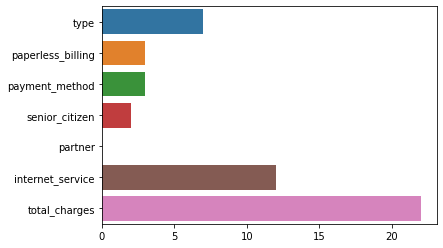

In [55]:
model = LGBMClassifier(learning_rate=0.5, max_depth=3, n_estimators=7,
                       objective='binary', random_state=80822,
                       reg_alpha=0.3)
model.fit(x_upsampled, y_upsampled)

sns.barplot(x=model.feature_importances_, y=train_x.columns)

Признак *Partner* оказался совсем бесполезным. 

## Тестирование

In [59]:
probs = model.predict_proba(test_x)
probs = probs[:, 1]
roc_auc_score(test_y, probs)

0.8535695548257971

**Итоговая метрика - ROC_AUC - равна 0.8535**

Text(0.5, 1.0, 'ROC-кривая')

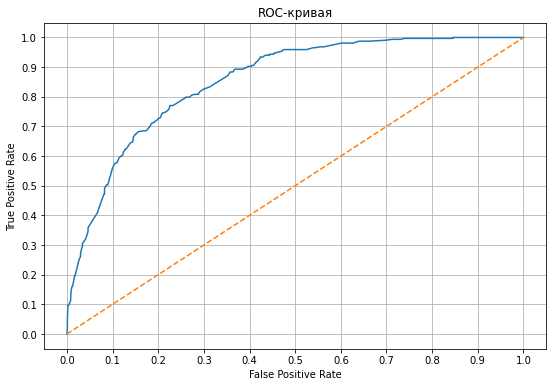

In [61]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(test_y, probs)

plt.figure(figsize=(9,6))
plt.grid(True)
plt.xticks(np.arange(0,1.01,0.1))
plt.yticks(np.arange(0,1.01,0.1))
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--') 
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC-кривая')

Цель выполнена, модель может прогнозировать уход клиента.